Simulations

In [60]:
import pandas as pd
import numpy as np 
import ndd

def generate_urn_sequence(N=1000, p0=0.2, p1=0.8, h=0.1, start_urn=None):

    # Urn sequence
    urn_sequence = np.zeros(N, dtype=bool)
    if start_urn is None:
        urn_sequence[0] = np.random.binomial(1, 0.5)==1
    for i, f in enumerate(np.random.binomial(1, h, size=N-1)):
        urn_sequence[i+1] = ~urn_sequence[i] if f==1 else urn_sequence[i]

    # Bead sequence
    bead_sequence = np.zeros(N, dtype=bool)
    bead_sequence[~urn_sequence] = np.random.binomial(1, p0, size=np.count_nonzero(~urn_sequence))==1
    bead_sequence[urn_sequence] = np.random.binomial(1, p1, size=np.count_nonzero(urn_sequence))==1

    # Return the sequences as dataframe
    return pd.DataFrame({'urn' : urn_sequence, 'bead' : bead_sequence})

# Get windowed sequence
def get_windowed_xs(x,z,w=1):
    xc = np.array(x.copy())
    zw = z[w-1:].copy()
    aux_base = 2**np.arange(w)
    xw_binned = np.array([np.inner(xc[i:i+w], aux_base) for i in np.arange(len(zw))]).astype(int)
    return(xw_binned, zw)

# Calculate mutual information using NSB method    
def mutual_inf_nsb(x, y, ks):
    ar = np.column_stack((x, y))
    mi = ndd.mutual_information(ar, ks)
    return np.log2(np.e)*mi # ndd returns nats - multiply by log2(e) to convert to bits

def get_i_past(x, z, w):
    x_w, z_w = get_windowed_xs(x, z, w)
    i_past = mutual_inf_nsb(x_w, z_w, [2**w,2])
    return(i_past)

In [42]:
from embo import InformationBottleneck as IB
cmap = plt.get_cmap("tab10")

def gensimplot(beads, urns, max_win_size):
    for w in range(1,max_win_size+1):
        # Compute using built-in windowing
        I_x, I_y, _, _ = IB(beads, urns, window_size_x=w, window_size_y=1).get_bottleneck()

        # Compute after windowing
        #(beads_w, urns_w) = get_windowed_xs(beads, urns, w)
        #I_x_w, I_y_w, _, _ = IB(beads_w, urns_w, window_size_x=1, window_size_y=1).get_bottleneck()

        plt.plot(I_x,  I_y,  color = cmap(w), marker = '+', label = w)
        #plt.plot(I_x_w, I_y_w, color = cmap(w), marker = '.')
        plt.legend()

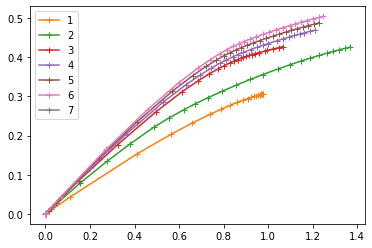

In [69]:
N = 1000
p0 = 0.2
p1 = 1-p0
h  = 0.075
max_win_size = 7
us = generate_urn_sequence(N, p0, p1, h)

beads = us['bead'].astype(int)
urns = us['urn'].astype(int)

gensimplot(beads, urns, max_win_size)

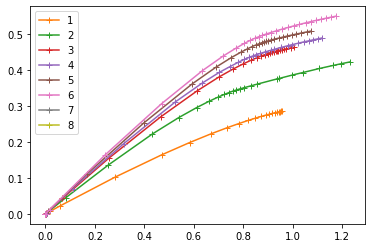

In [46]:
N = 1000
p0 = 0.2
p1 = 1-p0
h  = 0.05
max_win_size = 8
us = generate_urn_sequence(N, p0, p1, h)

beads = us['bead'].astype(int)
urns = us['urn'].astype(int)

gensimplot(beads, urns, max_win_size)

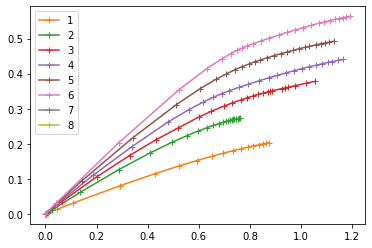

In [48]:
N = 1000
p0 = 0.2
p1 = 1-p0
h  = 0.01
max_win_size = 8
us = generate_urn_sequence(N, p0, p1, h)

beads = us['bead'].astype(int)
urns = us['urn'].astype(int)

gensimplot(beads, urns, max_win_size)

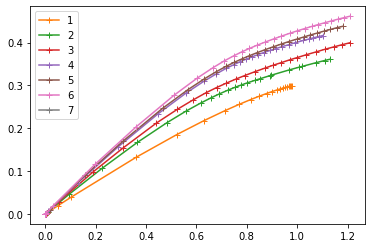

In [45]:
N = 900
p0 = 0.2
p1 = 1-p0
h  = 0.1
max_win_size = 7
us = generate_urn_sequence(N, p0, p1, h)

beads = us['bead'].astype(int)
urns = us['urn'].astype(int)

gensimplot(beads, urns, max_win_size)

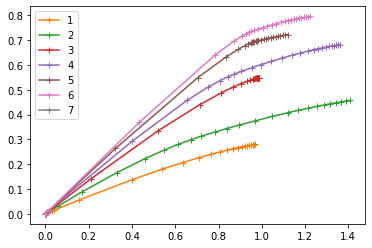

In [49]:
N = 1000
p0 = 0.2
p1 = 1-p0
h  = 0.01
max_win_size = 7
us = generate_urn_sequence(N, p0, p1, h)

beads = us['bead'].astype(int)
urns = us['urn'].astype(int)

gensimplot(beads, urns, max_win_size)

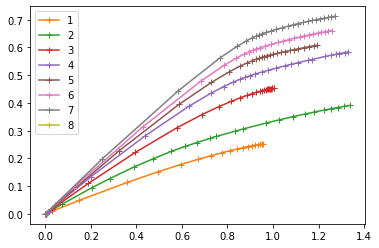

In [53]:
N = 2000
p0 = 0.2
p1 = 1-p0
h  = 0.01
max_win_size = 8
us = generate_urn_sequence(N, p0, p1, h)

beads = us['bead'].astype(int)
urns = us['urn'].astype(int)

gensimplot(beads, urns, max_win_size)

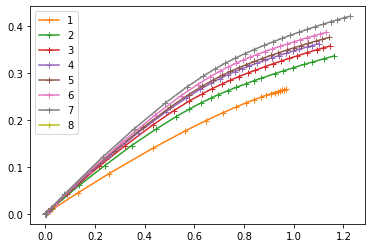

In [54]:
N = 2000
p0 = 0.2
p1 = 1-p0
h  = 0.1
max_win_size = 8
us = generate_urn_sequence(N, p0, p1, h)

beads = us['bead'].astype(int)
urns = us['urn'].astype(int)

gensimplot(beads, urns, max_win_size)

Text(0.5, 0, 'Window size of $X$ into the past')

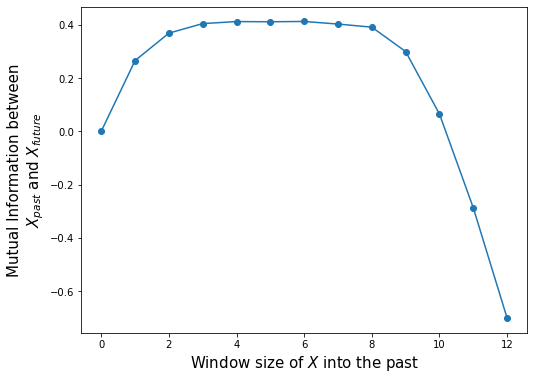

In [70]:
N = 1000
p0 = 0.2
p1 = 1-p0
h  = 0.1
us = generate_urn_sequence(N, p0, p1, h)

beads = us['bead'].astype(int)
urns = us['urn'].astype(int)

# Test bounds in each session
def get_windowed_mi(x,z,nw):
    '''
    Function that windows of observations from a sequence x offset from y and computes the MI
    Input:
        - x: sequence of "past" observations to be windowed
        - z: sequence that serves as the "future" events
        - nw: maximum window size
    Output:
        - mis: NSB estimated mutual informtion values for each window size
    '''
    mis = np.zeros(nw+1) #vector of mutual informations for different window sizes
    for w in np.arange(1,nw+1):
        mis[w] = get_i_past(x,z,w)
    return(mis)

# Get all trials in all three sessions that match low and high hazard rates
nw = 12 #number of windows into the past we want to compute

# Computed windowed predictive information in the low hazard rate
Ipast_windows = get_windowed_mi(beads,urns,nw)

# Plot predictive information as a function of window size
plt.figure(1,(8,6))
plt.plot(np.arange(nw+1),Ipast_windows,'-o')
plt.ylabel('Mutual Information between\n$X_{past}$ and $X_{future}$',size=15)
plt.xlabel('Window size of $X$ into the past',size=15)